In [1]:
from pathlib import Path

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm

from speaker_recognition import Conformer, ModelParams, SpeakerDataset

plt.style.use("ggplot")

### [VoxTube](https://github.com/IDRnD/VoxTube) Russian Subset

In [2]:
conf = ModelParams()

model = Conformer(conf)

ckpt = torch.load("./data/epoch_100.ckpt", map_location="cpu")

model.load_state_dict(ckpt["model_state_dict"])
model.eval();

In [3]:
sum(torch.numel(param) for param in model.parameters())

58137

In [4]:
dataset = SpeakerDataset(dataset_folder=Path("./data/dev"))

In [5]:
embs = []
labels = []

with torch.no_grad():
    for idx, wav, label in tqdm(dataset):
        emb, _ = model(wav.unsqueeze(0))
        embs.append(emb)
        labels.append(label)

np_labels = np.array(labels)

embs_matrix = torch.cat(embs)
embs_matrix = embs_matrix / (embs_matrix**2).sum(1, keepdim=True) ** 0.5

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2060/2060 [00:07<00:00, 261.58it/s]


In [6]:
scores = (embs_matrix @ embs_matrix.T).numpy()

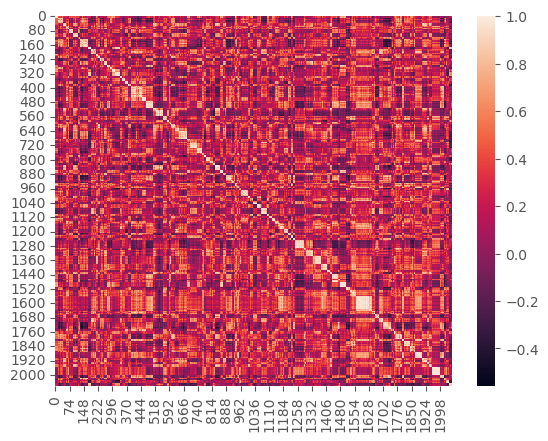

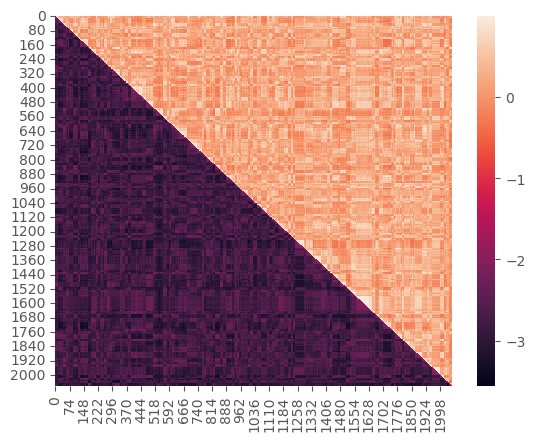

In [7]:
sns.heatmap(scores)
plt.show()

mask = np.tril(np.ones_like(scores)) * (-3)
masked_scores = scores + mask

sns.heatmap(masked_scores)
plt.show()

In [8]:
pos_total = []
neg_total = []

for voiceid in np.unique(np_labels):
    (idx,) = (np_labels == voiceid).nonzero()

    pos_scores = masked_scores[idx, :][:, idx]
    pos_scores = pos_scores[pos_scores > -1]

    other_idx_mask = ~np.isin(np.arange(masked_scores.shape[1]), idx)
    neg_scores = masked_scores[idx, :][:, other_idx_mask]
    neg_scores = neg_scores[neg_scores > -1]

    pos_total.extend(pos_scores)
    neg_total.extend(neg_scores)

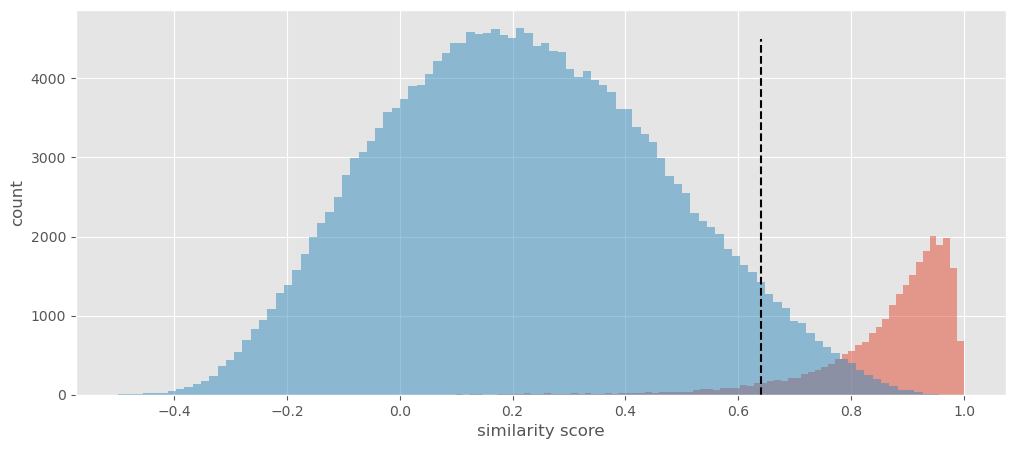

In [9]:
neg_sampled = np.random.choice(neg_total, size=int(len(neg_total) * 0.1), replace=False)

plt.figure(figsize=(12, 5))
plt.hist(pos_total, bins=100, alpha=0.5)
plt.hist(neg_sampled, bins=100, alpha=0.5)
plt.plot([0.64, 0.64], [0, 4500], "k--")
plt.xlabel("similarity score")
plt.ylabel("count")
plt.show()

In [10]:
bin_labels = np.concatenate((np.zeros_like(neg_total), np.ones_like(pos_total))).astype(
    "int"
)
bin_scores = np.concatenate((neg_total, pos_total))

order = bin_scores.argsort()

sort_bin_labels = bin_labels[order]
sort_bin_scores = bin_scores[order]

neg_count = np.zeros_like(sort_bin_labels)
pos_count = np.zeros_like(sort_bin_labels)

for i, label in enumerate(sort_bin_labels):
    neg_count[i] = (label == 0) + (neg_count[i - 1] if i > 0 else 0)
    pos_count[i] = (label == 1) + (pos_count[i - 1] if i > 0 else 0)

neg_cnt_total = neg_count[-1]
pos_cnt_total = pos_count[-1]

borders = (sort_bin_scores[1:] + sort_bin_scores[:-1]) / 2

frr = []
far = []

for n, p in zip(neg_count, pos_count):
    tn = n
    fp = neg_cnt_total - tn
    fn = p
    tp = pos_cnt_total - p

    frr.append(fn / (fn + tp))
    far.append(fp / (fp + tn))

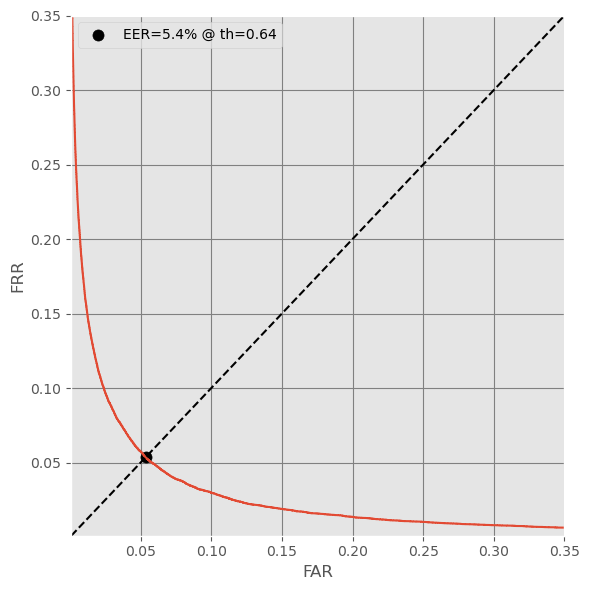

In [11]:
eer_idx = np.abs(np.array(frr) - np.array(far)).argmin()

EER = (frr[eer_idx] + far[eer_idx]) / 2

plt.figure(figsize=(6, 6))
plt.plot(far, frr)
plt.plot([1e-3, 1], [1e-3, 1], "k--")
plt.scatter(
    EER, EER, s=64, c="k", label=f"EER={EER * 100:.1f}% @ th={borders[eer_idx]:.2f}"
)
plt.xlim([1e-3, 0.35])
plt.ylim([1e-3, 0.35])
plt.legend(labelcolor="k")
plt.xlabel("FAR")
plt.ylabel("FRR")
plt.tight_layout()
plt.grid(c="gray")
plt.savefig("DET_curve.png", dpi=300, transparent=True);

In [12]:
large_scores = np.triu(scores * (scores > 0.9), k=1)

low_scores = np.triu(scores * (scores < 0.2), k=1)

fp_errors = []
fn_errors = []

for i, voiceid in enumerate(np.unique(np_labels)):

    (idx,) = (np_labels == voiceid).nonzero()

    x_id_fp, y_id_fp = large_scores[idx, :].nonzero()
    x_id_fn, y_id_fn = low_scores[idx, :].nonzero()

    x_id_fp += min(idx)
    x_id_fn += min(idx)

    fp_err_ids = np.isin(y_id_fp, (np_labels != voiceid).nonzero())
    fn_err_ids = np.isin(y_id_fn, idx)

    for query, result in zip(x_id_fp[fp_err_ids], y_id_fp[fp_err_ids]):
        fp_errors.append((query, result, scores[query, result]))

    for query, result in zip(x_id_fn[fn_err_ids], y_id_fn[fn_err_ids]):
        fn_errors.append((query, result, scores[query, result]))

In [13]:
wavs = [wav for _, wav, _ in dataset]

In [14]:
TOP_K = 3
SR = 16_000

sorted_fp_errors = sorted(fp_errors, key=lambda x: -x[2])

sorted_fn_errors = sorted(fn_errors, key=lambda x: x[2])


def display_erorrs(sorted_errors) -> None:
    for q_id, r_id, score in sorted_errors:
        print(f"{score:.2f}")
        ipd.display(ipd.YouTubeVideo(dataset.wav_files[q_id].parent.stem))
        ipd.display(ipd.YouTubeVideo(dataset.wav_files[r_id].parent.stem))
        ipd.display(ipd.Audio(wavs[q_id], rate=SR))
        ipd.display(ipd.Audio(wavs[r_id], rate=SR))

### False Positive

0.98


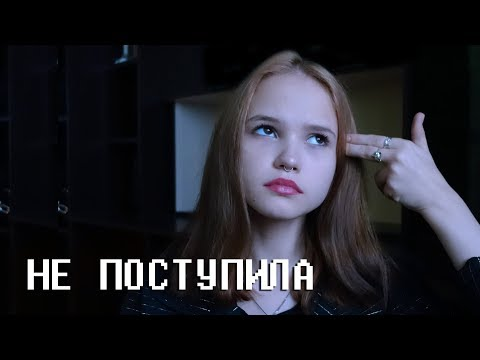

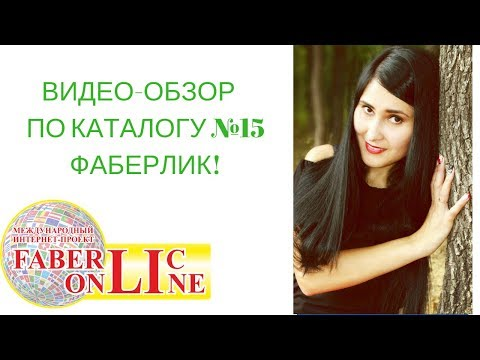

0.97


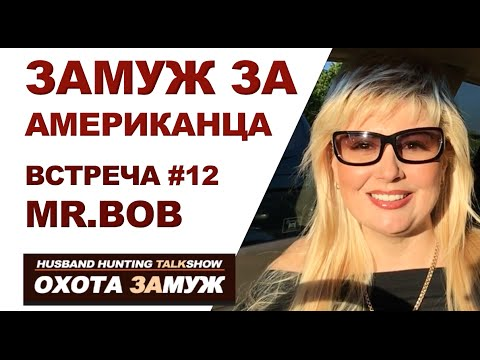

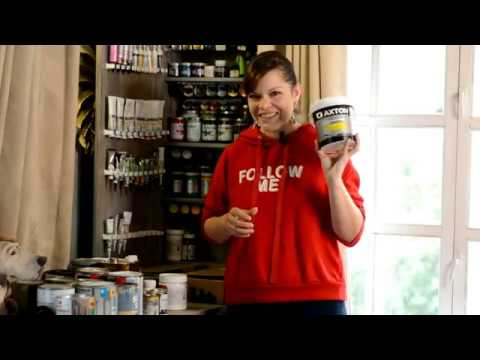

0.97


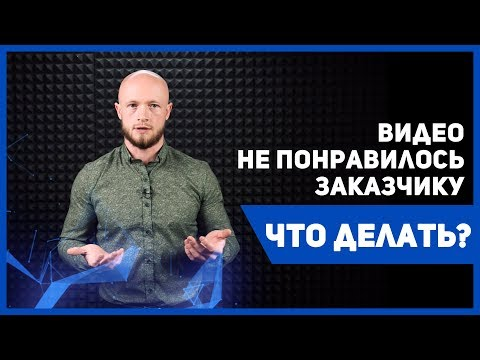

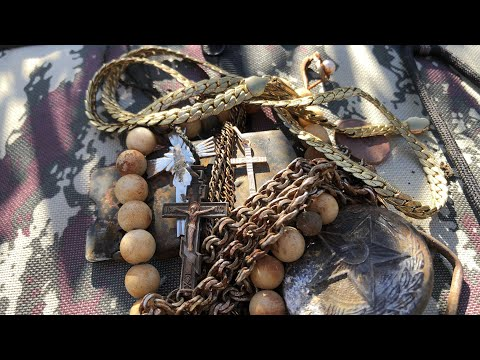

In [15]:
display_erorrs(sorted_fp_errors[:TOP_K])

### False Negative

-0.20


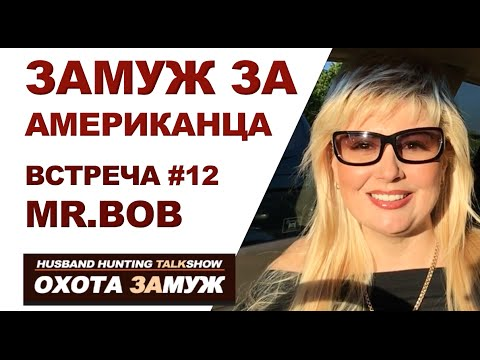

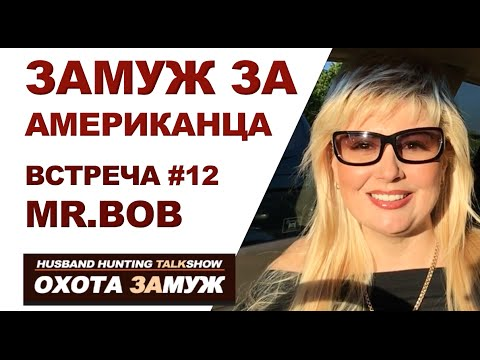

-0.19


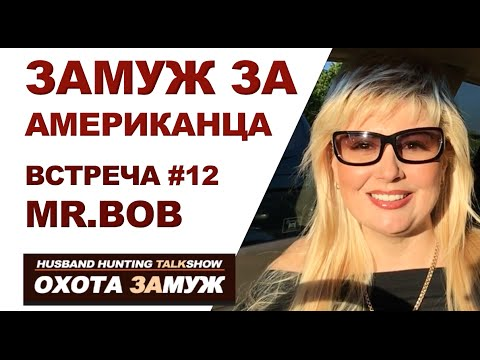

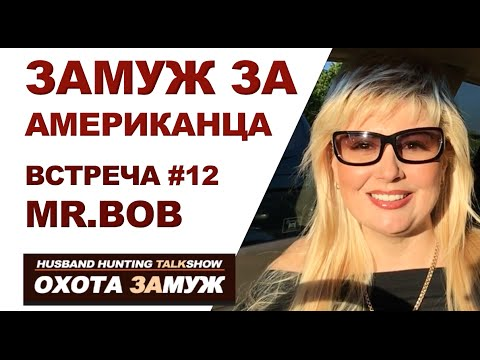

-0.16


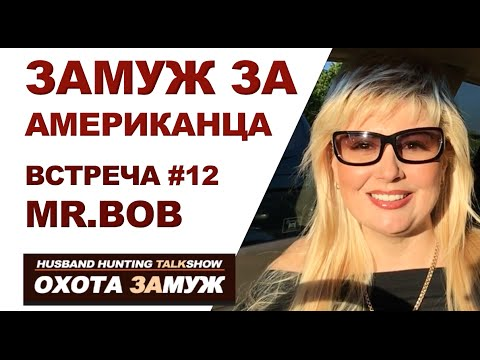

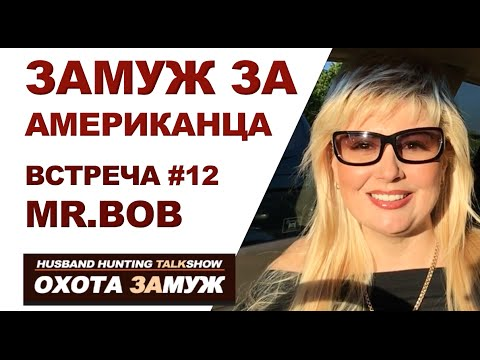

In [16]:
display_erorrs(sorted_fn_errors[:TOP_K])